In [1]:
%pip install datasets torchsummary

/bin/bash: /opt/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torchvision import models, transforms
from torchvision import transforms
from torchvision import models
#from datasets import load_dataset
from tqdm import tqdm
import torchvision.models as models
# from torchvision.datasets import ImageNet
from torchvision.datasets import ImageFolder
# from fastai.vision.all import *
# import matplotlib.pyplot as plt
#from fastai.vision.augment import Resize
from torch.utils.data import DataLoader
import numpy as np

In [3]:
path = 'imagenette2-160/'

In [4]:
# Define ImageNet normalization statistics

# Create common transformations for both training and validation
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply transformations directly to datasets
train_dataset = ImageFolder(root=path + '/train', transform=common_transforms)
val_dataset = ImageFolder(root=path + '/val', transform=common_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 8, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers = 8, pin_memory = True)

/net/dali/home/mscbio/gak147/.conda/envs/torch_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
for images, labels in train_loader:
    shape  = images.size()
    print(images.size())  # This will give you the size of the images batch
    break  # Exit after the first batch

torch.Size([64, 3, 224, 224])


In [6]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
num_classes = len(train_dataset.classes)
print(num_classes)

10


In [10]:
# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # torch.autograd.set_detect_anomaly(True)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradients for faster inference
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predictions

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

In [11]:
#figure out index of last fully connected layer
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [12]:
### ORIGINAL - NO CHANGES BESIDES LAST LAYER

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# model.fc = nn.Linear(model.fc.in_features, num_classes)

# for param in model.fc.parameters():
#   param.requires_grad = True

# Modify the final fully connected layer (classifier) to have 10 output classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Assuming the original last layer is at index 6

# Unfreeze the last fully connected layer (only the new last layer will be trained)
for param in model.classifier[6].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [13]:
# Set the device (either 'cuda' for GPU or 'cpu' for CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device
model = model.to(device)

In [14]:
# Training loop
num_epochs = 10
train_losses = np.zeros(num_epochs)
val_accuracies = np.zeros(num_epochs)
for epoch in np.arange(num_epochs):
    train_losses[epoch] = train(model, train_loader, criterion, optimizer, device)
    val_accuracies[epoch] = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[epoch]:.4f}, Val Accuracy: {val_accuracies[epoch]:.4f}")

100%|██████████| 62/62 [00:09<00:00,  6.57it/s]


Epoch 1, Train Loss: 0.3555, Val Accuracy: 0.9327


100%|██████████| 62/62 [00:08<00:00,  7.11it/s]


Epoch 2, Train Loss: 0.1950, Val Accuracy: 0.9455


100%|██████████| 62/62 [00:08<00:00,  7.45it/s]


Epoch 3, Train Loss: 0.1694, Val Accuracy: 0.9439


100%|██████████| 62/62 [00:08<00:00,  7.52it/s]


Epoch 4, Train Loss: 0.1540, Val Accuracy: 0.9473


100%|██████████| 62/62 [00:08<00:00,  7.18it/s]


Epoch 5, Train Loss: 0.1384, Val Accuracy: 0.9468


100%|██████████| 62/62 [00:08<00:00,  7.20it/s]


Epoch 6, Train Loss: 0.1305, Val Accuracy: 0.9465


100%|██████████| 62/62 [00:09<00:00,  6.65it/s]


Epoch 7, Train Loss: 0.1268, Val Accuracy: 0.9501


100%|██████████| 62/62 [00:08<00:00,  7.05it/s]


Epoch 8, Train Loss: 0.1158, Val Accuracy: 0.9460


100%|██████████| 62/62 [00:08<00:00,  7.21it/s]


Epoch 9, Train Loss: 0.1129, Val Accuracy: 0.9485


100%|██████████| 62/62 [00:08<00:00,  7.41it/s]

Epoch 10, Train Loss: 0.1024, Val Accuracy: 0.9490


In [17]:
# # NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
# model2 = model

# # Freeze all parameters first
# for param in model2.parameters():
#     param.requires_grad = False

# # # replace the last conv 2d layer with a linear layer
# new_layer = nn.Sequential(
#      nn.ReLU(),
#      nn.Linear(14,14), #I changed this to nn.Linear(7,7) when unfreezing this particular layer
#      nn.ReLU()
# )
# model2.features[29] = new_layer

# # model2.fc = nn.Linear(model.fc.in_features, num_classes)
# model2.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


# for param in model2.classifier[6].parameters():
#   param.requires_grad = True

# for param in model2.features[29].parameters():
#     param.requires_grad = True

# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)
# criterion = nn.CrossEntropyLoss()

In [27]:
# model2.to(device)

# summary(model2, (3, 224, 224))
# model2

In [28]:
# num_epochs = 10
# train_loss_changed = np.zeros(num_epochs)
# val_accuracy_changed = np.zeros(num_epochs)
# for epoch in range(num_epochs):
#     train_loss_changed[epoch] = train(model2, train_loader, criterion, optimizer, device)
#     val_accuracy_changed[epoch] = evaluate(model2, val_loader, device)
#     print(f"Epoch {epoch+1}, Train Loss: {train_loss_changed[epoch]:.4f}, Val Accuracy: {val_accuracy_changed[epoch]:.4f}")

In [29]:
# #code for plotting the graphs below - just copy-pasted the val and training values into lists
# epoch = [i for i in range(1,num_epochs+1)]
# plt.plot(epoch, val_accuracy_changed, label="Validation Accuracy with Layer Removed")
# plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
# plt.title("Validation Accuracy of VGG16 on Imagenette")
# plt.legend()
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")

# plt.show()
# # print(val_accuracy_changed)
# print(val_accuracies)

In [30]:
# plt.plot(epoch, train_loss_changed, label="Training Loss with Layer Removed")
# plt.plot(epoch, train_losses, label="Baseline Training Loss")
# plt.title("Training Loss of VGG16 on Imagenette")
# plt.ylabel("Training Loss")
# plt.xlabel("Epoch")
# plt.legend()
# plt.show()

# # print(train_loss_changed)
# print(train_losses)

In [21]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model3 = model

# Freeze all parameters first
for param in model3.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model3.features[28] = nn.Linear(14,14)

model3.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model3.classifier[6].parameters():
  param.requires_grad = True

for param in model3.features[28].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [22]:
model3.to(device)

summary(model3, (3, 224, 224))
model3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
num_epochs = 10
train_loss_changed_correct = np.zeros(num_epochs)
val_accuracy_changed_correct = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_changed_correct[epoch] = train(model3, train_loader, criterion, optimizer, device)
    val_accuracy_changed_correct[epoch] = evaluate(model3, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_changed_correct[epoch]:.4f}, Val Accuracy: {val_accuracy_changed_correct[epoch]:.4f}")

100%|██████████| 62/62 [00:08<00:00,  7.01it/s]


Epoch 1, Train Loss: 1.3908, Val Accuracy: 0.7997


100%|██████████| 62/62 [00:08<00:00,  7.01it/s]


Epoch 2, Train Loss: 0.6220, Val Accuracy: 0.8680


100%|██████████| 62/62 [00:09<00:00,  6.86it/s]


Epoch 3, Train Loss: 0.5221, Val Accuracy: 0.8736


100%|██████████| 62/62 [00:08<00:00,  6.99it/s]


Epoch 4, Train Loss: 0.4788, Val Accuracy: 0.8790


100%|██████████| 62/62 [00:09<00:00,  6.61it/s]


Epoch 5, Train Loss: 0.4538, Val Accuracy: 0.8864


100%|██████████| 62/62 [00:09<00:00,  6.86it/s]


Epoch 6, Train Loss: 0.4280, Val Accuracy: 0.8882


100%|██████████| 62/62 [00:08<00:00,  6.94it/s]


Epoch 7, Train Loss: 0.4205, Val Accuracy: 0.8907


100%|██████████| 62/62 [00:08<00:00,  6.95it/s]


Epoch 8, Train Loss: 0.4041, Val Accuracy: 0.8904


100%|██████████| 62/62 [00:09<00:00,  6.87it/s]


Epoch 9, Train Loss: 0.3947, Val Accuracy: 0.8915


100%|██████████| 62/62 [00:08<00:00,  6.96it/s]

Epoch 10, Train Loss: 0.3894, Val Accuracy: 0.8927


In [24]:
import matplotlib.pyplot as plt

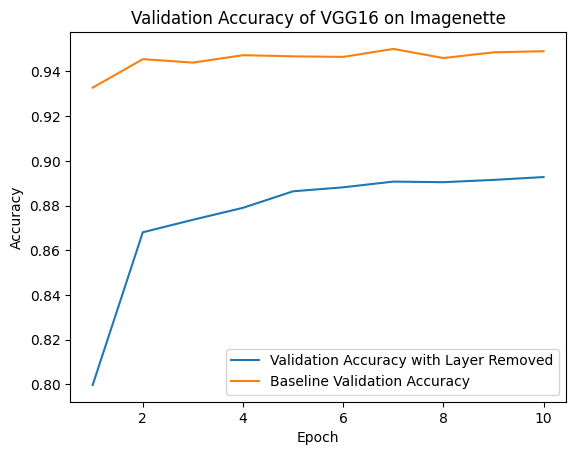

[0.93273885 0.94547771 0.94394904 0.94726115 0.94675159 0.94649682
 0.95006369 0.94598726 0.94853503 0.94904459]


In [25]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy_changed_correct, label="Validation Accuracy with Layer Removed")
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of VGG16 on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy_changed)
print(val_accuracies)

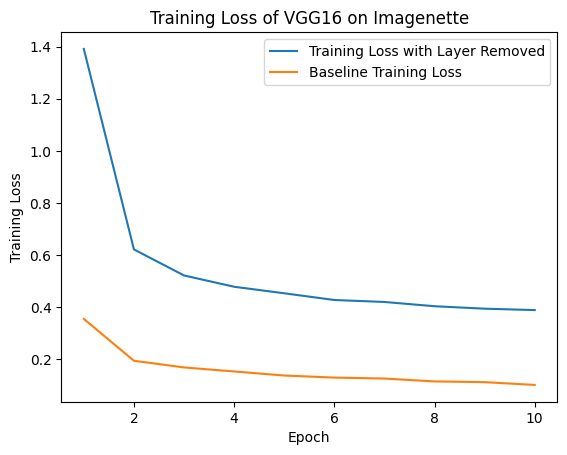

[0.35551925 0.1950045  0.16939413 0.15396993 0.13841327 0.13048469
 0.12684698 0.11576093 0.11293987 0.10235216]


In [26]:
plt.plot(epoch, train_loss_changed_correct, label="Training Loss with Layer Removed")
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.title("Training Loss of VGG16 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# print(train_loss_changed)
print(train_losses)